In [46]:
import glob,os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
import re
import scipy.stats as st
from os.path import expanduser
import cmath
import scipy.optimize as op
import time
import gzip
import pandas as pd
import scipy.special as sp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,inset_axes,InsetPosition)
from sympy.solvers import solve
from sympy import Symbol
import sympy
%matplotlib inline

In [2]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "serif"

start = time.time()

home = os.path.expanduser("~")

direc = os.listdir(".")

In [3]:
# Smoothing the data

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [4]:
# ASSUMPTION = t and m are panda dataframes
# Create a function that: 
# 1- Smoothes the lightcurve
# 2- Divides it into bins of arbitrary sizes
# 3- Calculates (m - mean)/std(m)
# 4- Counts the number of outliers in each bin with deviations larger than threshold*sigma

def count_peaks (t, m, smooth='yes', bin_size = 30, threshold = 3):
    
    if smooth == 'yes':
        m = low_pass_filter(m,8)
    else:
        pass
    
    bins = np.linspace(t.min(),t.max(),int((t.max()-t.min())/bin_size))
    groups = df.groupby(np.digitize(t, bins))
    
    std_ = np.std(m)
    delta_m = []
    t__ = []
    c=0
    for i in groups.indices:
        #print c
        c = c+1
        #print i
        m_ = m[groups.indices[i]]
        t_ = t[groups.indices[i]]
        #print t,m
        del_m = np.asarray((np.abs(m_- m_.mean())/std_))
        delta_m.append(del_m)
        t__.append(np.asarray(t_))
    peaks = []    
    n_outliers = []
    for j in range(len(delta_m)):
        n_temp = len(np.where(delta_m[j]>threshold)[0])
        n_outliers.append(n_temp) 
        if n_temp > 0 :
            peaks.append(t__[j][np.argmax(delta_m[j])])
    return n_outliers, peaks

In [5]:
def empty(df):
    return len(df.index) == 0
    
def fwhm(valuelist, peakpos,base):
    peakvalue = valuelist[peakpos]-base
    phalf = (peakvalue / 2.0)+base

    # go left and right, starting from peakpos
    ind1 = peakpos
    ind2 = peakpos   

    while ind1>2 and valuelist[ind1]<phalf:
        ind1=ind1-1
    while ind2<len(valuelist)-1 and valuelist[ind2]<phalf:
        ind2=ind2+1  
    return ind1,ind2

def tE_finder (t,m, t0, m_base):
    df = pd.DataFrame({'t' : t, 'm' : m})
    
    m_A134 = m_base - (np.log10(1.34)/0.4) 
    
    
    t_max = t0
    t_right = df['t'][df['t']>t_max]
    
    t_left = df['t'][df['t']<t_max]
    
    
    if not len(t_right) == 0  :
        
        tE_right = np.abs(t_right[(np.abs(df['m'][df['t']>t_max]-(m_A134))).argmin()]-t_max)
    else:
        tE_right = 1
        
    if not len(t_left)==0 :
        tE_left = np.abs(t_left[(np.abs(df['m'][df['t']<t_max]-(m_A134))).argmin()]-t_max)
        
    else:
        tE_left = 1
       
    
    return max([tE_right,tE_left])

def fun (t0,u0,tE, m_base):
    u = np.sqrt(u0**2+((df['t']-t0)/tE)**2)
    A = ((u**2)+2)/(u*np.sqrt(u**2+4))
    return m_base - (np.log10(A)/0.4)

def lnlike(theta, t, f, f_err):
    t0, u0, tE, base = theta
    model = fun(t0, u0, tE, base)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


In [6]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    return baseline, event, it0

In [7]:
def s_q_estimator (t, m, m_err , binsize = 5):
    
    df = pd.DataFrame({'t':t , 'm':m , 'm_err' : m_err})
    t0 = df['t'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.2,100])[0]])]
    baseline, event, it0 = localize_event(df['t'], t0, 30)
    base_mag = np.median(df['m'][baseline])
    
    plt.figure(1)
    plt.plot(df['t'][event],df['m'][event],'b.')
    plt.plot(df['t'][baseline],df['m'][baseline],'r.')
    plt.axvline(t0)
    plt.xlim(t0-60, t0+60)
    plt.gca().invert_yaxis()
    
    m_max = df['m'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.2,100])[0]])]
    A_max = 10 ** (0.4*(base_mag - m_max))
    u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
    ind1, ind2 = fwhm(df['m'],np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.2,100])[0]]),base_mag)
    tE_A134 = tE_finder (df['t'],df[ 'm'],t0, base_mag)
    tE_true = [tE_A134 , t[ind2]-t[ind1]]
    print tE_true
    tE_ = [[],[]]    
    for i in tE_true:

        nll = lambda *args: -lnlike(*args)
        result = op.minimize(nll, [t0_true, u0_true, i, base_mag], args=(df['t'],df[ 'm'], df['m_err']),method = 'Nelder-Mead')
        t0_ml, u0_ml, tE_ml, base_ml = result['x']
        tE_[0].append(-2*lnlike([t0_ml, u0_ml, tE_ml, base_ml],df['t'],df[ 'm'], df['m_err']))
        tE_[1].append([t0_ml, u0_ml, tE_ml, base_ml])
        
    mm = np.asarray( tE_[0])
    tE__ = tE_[1][mm.argmin()]

    t0_ml, u0_ml, tE_ml,base_ml = tE__[0],tE__[1],tE__[2],tE__[3]
    
    plt.figure(2)
    plt.plot(df['t'],df['m'],'b.')
    plt.plot(df['t'],fun(t0_ml, u0_ml, tE_ml,base_ml),'r')
    plt.gca().invert_yaxis()
    
    f_res = df['m']-fun(t0_ml, u0_ml, tE_ml,base_ml)
    
    n_out, peaks = count_peaks (t, f_res, smooth='yes', bin_size = binsize, threshold = 3)
    
    plt.figure(3)
    plt.plot(df['t'],f_res,'b.')
    plt.xlim(t0-100, t0+100)
    plt.gca().invert_yaxis()
    
    if len(peaks)==2:
        u = []
        for peak in peaks:
            plt.axvline(peak)
            m1 = df['m'][df['t']==peak]
            A1 = 10** (0.4*(base_mag-m1))
            u1 = np.sqrt( ((peak-t0_ml)/tE_ml)**2 + (u0_ml)**2 )
            u.append(u1)
    elif len(peaks)==1:
        
        raise NameError('One peak was found in the residual')
        
        
    else:
        plt.figure(4)
        plt.plot(df['t'],f_res,'b.')
        plt.xlim(t0_ml-tE_ml, t0_ml+tE_ml)
        for peak in peaks:
            plt.axvline(peak)
            plt.gca().invert_yaxis()
        
        raise NameError("More than two peaks were found in the residual.")
        
        
    
        
    s0s1 = np.sqrt( (u[0])**2 + (u0_ml)**2 )
    s0s2 = np.sqrt( (u[1])**2 + (u0_ml)**2 )
    s1s2 = s0s1 - s0s2
    xs1 = (s1s2 * s0s1) / u[0]
    Lx = u[0] - xs1
    
    
    x = Symbol('x')
    s = solve(x-(1/x)-Lx, x)
    
    #if df['m'][df['t']==peaks] <0 :
    
    
    q = ( xs1*s[1]*np.sqrt(float(s[1]**2 -1))/2 )**2
    
    return s[1], q


    
    

In [134]:
name = 'OGLE-2012-BLG-0406.txt'  
tempdata = 'data/OGLE-2012-BLG-0406/'+str(name)

In [135]:
t,m,m_err,seeing,skylevel = np.loadtxt(tempdata,usecols=(0,1,2,3,4),unpack=True)
df = pd.DataFrame({'t':t , 'm':m , 'm_err' : m_err , 'seeing': seeing, 'skylevel':skylevel})


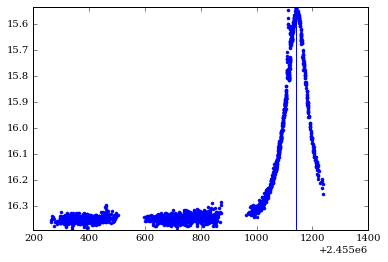

In [136]:
plt.plot(df['t'],df['m'],'b.')
plt.ylim(np.percentile(df['m'], [0.3,100]))
plt.axvline(df['t'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.3,100])[0]])])
#plt.xlim(1350,1420)
plt.gca().invert_yaxis()

In [137]:
t0 = df['t'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.3,100])[0]])]

In [138]:
baseline, event, it0 = localize_event(df['t'], t0,20)

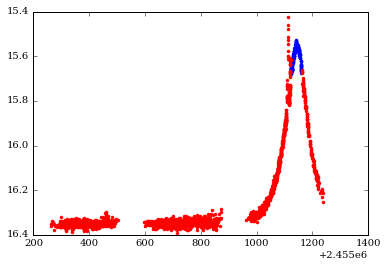

In [139]:
plt.plot(df['t'][event],df['m'][event],'b.')
plt.plot(df['t'][baseline],df['m'][baseline],'r.')
#plt.xlim(1350,1420)
plt.gca().invert_yaxis()

In [140]:
base_mag = np.median(df['m'][baseline])
m_max = df['m'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.3,100])[0]])]
A_max = 10 ** (0.4*(base_mag - m_max))
u0_true = np.sqrt( ( (1+np.sqrt(1+16*(A_max**2)))/(2* A_max) ) - 2 )
t0_true =  t0
ind1, ind2 = fwhm(df['m'],np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.3,100])[0]]),base_mag)
tE_true = [tE_finder (df['t'],df[ 'm'],t0, base_mag), t[ind2]-t[ind1]]

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [141]:
u = Symbol('u')
uu = solve( (((u**2)+2)/(u*sympy.sqrt(u**2+4))) - A_max, u)

In [142]:
uu

[0.523593502967760, 2.06740178880402*I]

In [143]:
tE_true

[54.8816499998793, 85.854379999917]

In [144]:
tE_ = [[],[]]    
for i in tE_true:
               
    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [t0_true, u0_true, i, base_mag], args=(df['t'],df[ 'm'], df['m_err']),method = 'Nelder-Mead')
    t0_ml, u0_ml, tE_ml, base_ml = result['x']
    tE_[0].append(-2*lnlike([t0_ml, u0_ml, tE_ml, base_ml],df['t'],df[ 'm'], df['m_err']))
    tE_[1].append([t0_ml, u0_ml, tE_ml, base_ml])

In [145]:
tE_[0]

[57428.57072267564, 57428.570720975826]

In [146]:
#print tE_[1]
mm = np.asarray( tE_[0])
tE__ = tE_[1][mm.argmin()]

t0_ml, u0_ml, tE_ml,base_ml = tE__[0],tE__[1],tE__[2],tE__[3]


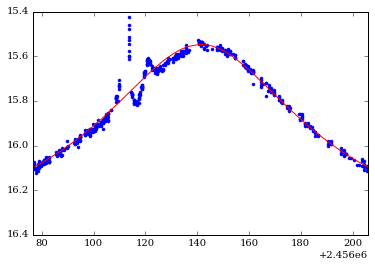

In [153]:
plt.plot(df['t'],df['m'],'b.')
plt.plot(df['t'],fun(t0_ml, u0_ml, tE_ml,base_ml),'r')
plt.xlim(t0_ml-1*tE_ml, t0_ml+1*tE_ml)
plt.gca().invert_yaxis()

In [23]:
f_res = df['m']-fun(t0_ml, u0_ml, tE_ml,base_ml)

In [24]:
n_out, peaks = count_peaks (df['t'], f_res,smooth='yes', bin_size = 20, threshold = 3)

In [25]:
peaks


[2456113.68359, 2456120.77201]

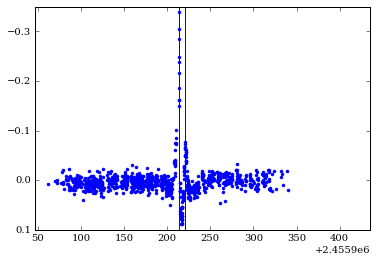

In [26]:
plt.plot(df['t'],f_res,'b.')
plt.xlim(t0_ml-3*tE_ml, t0_ml+3*tE_ml)
plt.axvline(peaks[0])
plt.axvline(peaks[1])
#plt.xlim(1410,1420)


plt.gca().invert_yaxis()

In [27]:
# Caustic crossing 1

m1 = df['m'][df['t']==peaks[0]]
A1 = 10** (0.4*(base_mag-m1))
u1 = np.sqrt( ((peaks[0]-t0_ml)/tE_ml)**2 + (u0_ml)**2 )

In [28]:
# Caustic crossing 2

m2 = df['m'][df['t']==peaks[1]]
A2 = 10** (0.4*(base_mag-m2))
u2 = np.sqrt( ((peaks[1]-t0_ml)/tE_ml)**2 + (u0_ml)**2 )

In [29]:
alpha = np.arcsin(u0_ml/u1)

In [30]:
# For the case of s>1

s0s1 = np.sqrt( (u1)**2 + (u0_ml)**2 )
s0s2 = np.sqrt( (u2)**2 + (u0_ml)**2 )
s1s2 = s0s1 - s0s2
xs1 = (s1s2 * s0s1) / u1
Lx = u1 - xs1

In [178]:
# For the case of s<1

s1s2 = np.sqrt(u1**2 - u0_ml**2) - np.sqrt(u2**2 - u0_ml**2)
Lx = (u1**2 + u2**2 -(s1s2**2)/2)/2
x1 = (np.arcsin(u0_ml/Lx)*180)/pi
s21 = (np.arcsin(u0_ml/u2)*180)/pi
s23 = 90 - x1
s22 = 180 - (s21+s23)
LO = u2 * np.sin((s22*pi)/180)

In [31]:
s1s2

0.04923135045386662

In [32]:
x = Symbol('x')
s = solve(x-(1/x)-Lx, x)

In [33]:
s

[-0.738396518937599, 1.35428590784636]

In [34]:
q = ( xs1*s[1]*np.sqrt(float(s[1]**2 -1))/2 )**2

In [35]:
q

0.00148308358492911

In [184]:
s

[-0.163211765093959, 6.12700928406916]

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[55.063549999613315, 83.9834400000982]


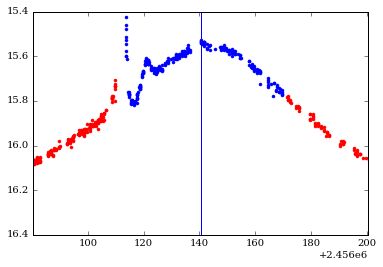

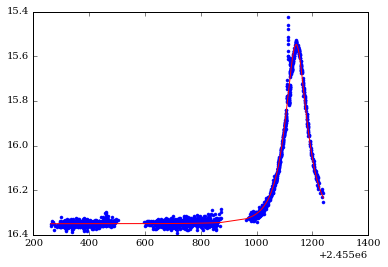

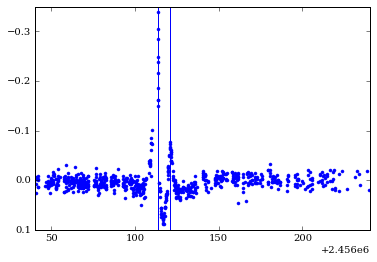

In [43]:
ss, qq = s_q_estimator(df['t'].values, df['m'].values, df['m_err'].values, binsize = 20)

In [44]:
ss

1.35428596264871

In [45]:
q

'3.94237e-05'

In [297]:
name = 'cassan_0_109_2397.det.lc.gz'  
tempdata = '/Users/Research/Desktop/alllc1/'+ str(name)
#'data/WFIRST_simulated/Multi_caustic_crossing/'+str(name)

t,f,f_err,f_true,code = np.loadtxt(tempdata,usecols=(0,1,2,3,5),unpack=True)
df = pd.DataFrame({'t':t , 'f':f , 'f_err' : f_err , 'f_true': f_true, 'code':code})
df = df[df['code']==0]

In [298]:
fname = gzip.open(tempdata, 'rb')
x_0 = fname.readlines()[0:7]
mag = x_0[1].split(' ')[3]
q = x_0[5].split(' ')[5]
s = x_0[5].split(' ')[6]

In [299]:
s

'0.683782'

In [300]:
df['m'] = float(mag) - np.log10(df['f'].values)/0.4
df['m_true'] = float(mag) - np.log10(df['f_true'].values)/0.4

In [301]:
#baseline , event, it0 = localize_event(df['t'],t0,tE)

(533.14918403, 493.14918403)

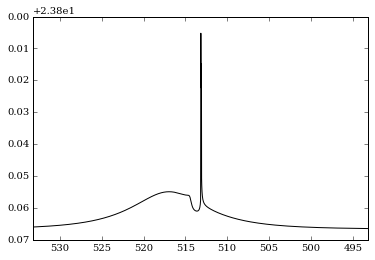

In [303]:
dt =20

plt.plot(df['t'],df['m_true'],'k-')
plt.gca().invert_yaxis()
plt.xlim(df.t[np.argmin(df.m_true)]+dt, df.t[np.argmin(df.m_true)]-dt)
# plt.ylim(21.2,20.3)

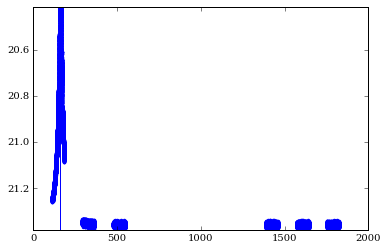

In [133]:
plt.plot(df['t'],df['m'],'b.')
plt.ylim(np.percentile(df['m'], [0.3,100]))
plt.axvline(df['t'][np.argmin(df['m'][df['m']>np.percentile(df['m'], [0.3,100])[0]])])
#plt.xlim(1300,1420)
plt.gca().invert_yaxis()

/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


[0.5912731999999323, 145.83851849999996]


NameError: More than two peaks were found in the residual.

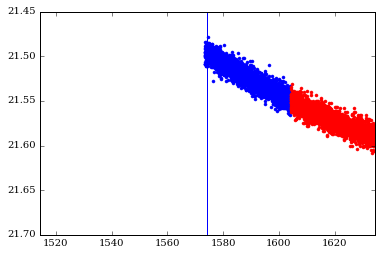

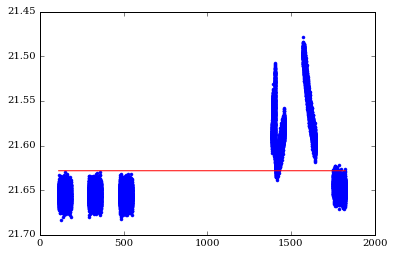

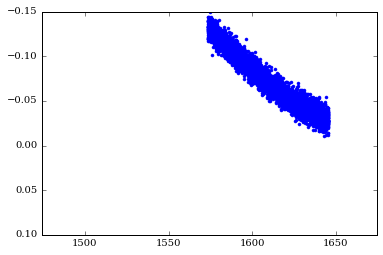

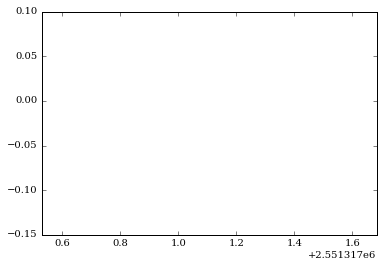

In [126]:
ss, qq = s_q_estimator(df['t'].values, df['m'].values, df['f_err'].values, binsize = 10)

In [294]:
ss

1.64245898285302

In [61]:
np.linspace(-100,100,1000)

array([-100.        ,  -99.7997998 ,  -99.5995996 ,  -99.3993994 ,
        -99.1991992 ,  -98.998999  ,  -98.7987988 ,  -98.5985986 ,
        -98.3983984 ,  -98.1981982 ,  -97.997998  ,  -97.7977978 ,
        -97.5975976 ,  -97.3973974 ,  -97.1971972 ,  -96.996997  ,
        -96.7967968 ,  -96.5965966 ,  -96.3963964 ,  -96.1961962 ,
        -95.995996  ,  -95.7957958 ,  -95.5955956 ,  -95.3953954 ,
        -95.1951952 ,  -94.99499499,  -94.79479479,  -94.59459459,
        -94.39439439,  -94.19419419,  -93.99399399,  -93.79379379,
        -93.59359359,  -93.39339339,  -93.19319319,  -92.99299299,
        -92.79279279,  -92.59259259,  -92.39239239,  -92.19219219,
        -91.99199199,  -91.79179179,  -91.59159159,  -91.39139139,
        -91.19119119,  -90.99099099,  -90.79079079,  -90.59059059,
        -90.39039039,  -90.19019019,  -89.98998999,  -89.78978979,
        -89.58958959,  -89.38938939,  -89.18918919,  -88.98898899,
        -88.78878879,  -88.58858859,  -88.38838839,  -88.18818

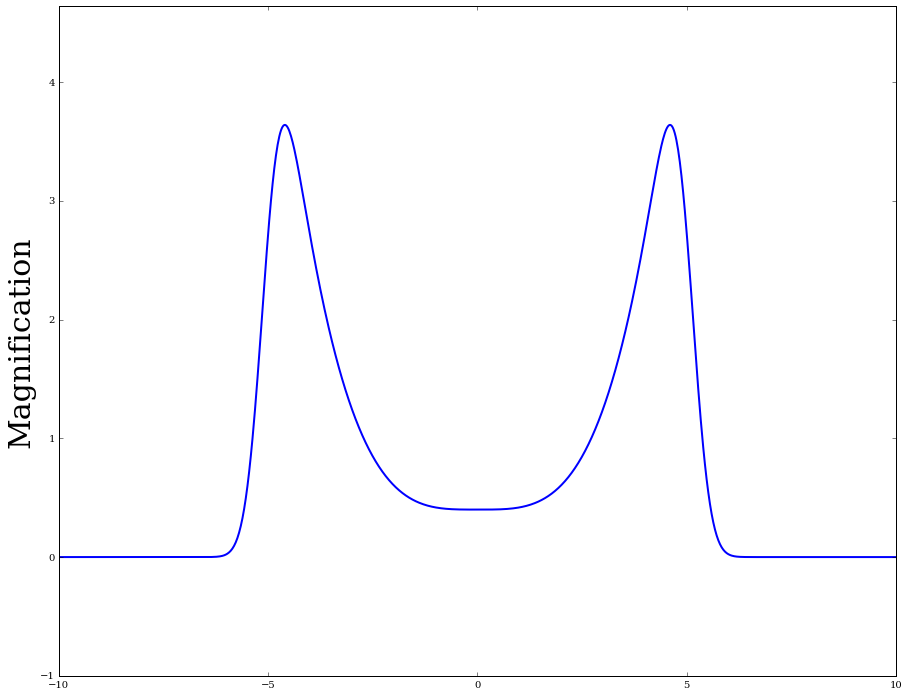

In [262]:
x = np.linspace(-10,10,1000)
a = 4
b1= 1
b2= 1
s = 2
w = 5*s
xe = 0
xp = 0
c = 0.004
n = 3.5
busy = ((a/4.) * (sp.erf(b1 * (w + s*x - xe))+1) * (sp.erf(b2 * (w - s*x + xe))+1) * (c* (np.abs(s*x-xp)**n)+1))/10

ax = plt.gca()
plt.plot(x, busy, linewidth = 2)
# plt.xlim(-1,1)
plt.ylim(min(busy)-1,max(busy)+1)
#ax.tick_params(axis='both',which='both', bottom='off', top='off',left = 'off', right='off', labelbottom='off', labelleft='off')
plt.ylabel('Magnification', size=30)
# plt.xlabel('Time', size=30)
fig = plt.gcf()
fig.set_size_inches(15.0,12.0)
# fig.savefig('Double_horn.png')

In [164]:
min(busy)

0.0